<div style="background-color: #8e7cc3; padding: 7px; text-align: center;">
    <h2>Projeto Machine Learning I | Problema de Classificação com KNN e Random Forest</h2>
</div>

#### Grupo:
- Matheus Mendonça Lopes (1116008)
- Otávio Teixeira Santos (1116014)
- Tainah Guerra Santos (1116005)

## Descrição

##### **Objetivo:** 
Esse projeto visa comparar a performance de modelos de K-Nearest Neighbors (KNN) e Random Forest para prever o diagnóstico de doença cardíaca pacientes dado um conjunto de informações sobre sua saúde. Temos, então, um problema de aprendizado de máquina **supervisionado de clasificação**.

##### **Dados:** 
Os dados usados foram originados combinando 5 diferentes bancos de dados em saúde cardíaca: Cleveland, Hungarian, Switzerland, Long Beach VA e Stalog (Heart) Data Set. O dataset completo pode ser encontrado [aqui](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction).

##### Abaixo, a descrição dos atributos presentes no dataset:

| Atributo                    | Descrição                                      | 
|-----------------------------|------------------------------------------------|
| Age                         | Idade do paciente (anos) |
| Sex                         | Sexo do paciente (M: Masculino, F: Feminino)                               |
| ChestPainType               | Tipo de dor no peito (TA: Angina Típica, ATA: Angina Atípica, NAP: Dor Não-Anginosa, ASY: Assintomático) |
| RestingBP                   | Pressão arterial em repouso (mm Hg) | 
| Cholesterol                 | Colesterol sérico (mm/dl) | 
| FastingBS                   | Açúcar no sangue em jejum (1: se FastingBS > 120 mg/dl, 0: caso contrário) | 
| RestingECG                  | Resultados do eletrocardiograma em repouso (Normal: Normal, ST: anormalidade de onda ST-T, LVH: mostrando hipertrofia ventricular esquerda provável ou definitiva) |
| MaxHR                       | Frequência cardíaca máxima alcançada (60-202) | 
| ExerciseAngina              | Angina induzida por exercício (Y: Sim, N: Não) | 
| Oldpeak                     | Valor do Oldpeak = ST |                         
| ST_Slope                    | Inclinação do segmento ST no pico do exercício (Up: inclinação ascendente, Flat: plana, Down: inclinação descendente)| 
| HeartDisease                | Classe de saída (1: Doença Cardíaca, 0: Normal) | 


## Importando Bibliotecas

In [235]:
# Manipulação e Visualização dos dados

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Pré-processamento

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Modelagem

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Métricas

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import roc_curve


## Análise Exploratória dos Dados

In [236]:
# Carregando dados

data = pd.read_csv('data/heart.csv')

In [237]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [238]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [239]:
# Checando valores duplicados e nulos

print(f'Total de valores duplicados: {data.duplicated().sum()}\n\nTotal de valores nulos por coluna:\n{data.isna().sum()}')

Total de valores duplicados: 0

Total de valores nulos por coluna:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [240]:
# Distribuições dos atributos numéricos

np.round(data[['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']].describe(),1)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,918.0,918.0,918.0,918.0,918.0,918.0
mean,53.5,132.4,198.8,0.2,136.8,0.9
std,9.4,18.5,109.4,0.4,25.5,1.1
min,28.0,0.0,0.0,0.0,60.0,-2.6
25%,47.0,120.0,173.2,0.0,120.0,0.0
50%,54.0,130.0,223.0,0.0,138.0,0.6
75%,60.0,140.0,267.0,0.0,156.0,1.5
max,77.0,200.0,603.0,1.0,202.0,6.2


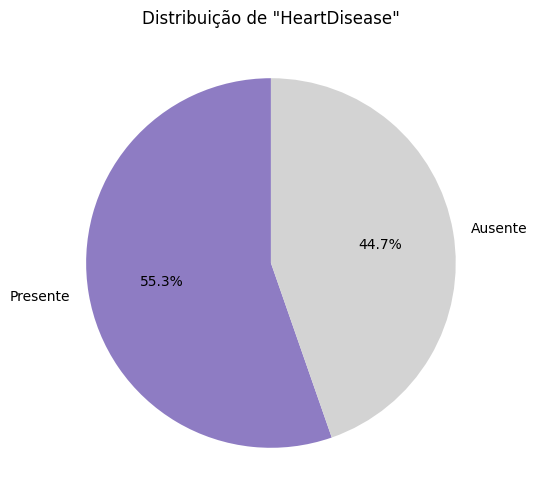

In [241]:
# Distribuição do atributo Doença Cardíaca

data_viz = data['HeartDisease'].map({1: 'Presente', 0: 'Ausente'})

plt.figure(figsize=(6, 6))  
plt.pie(data_viz.value_counts(), labels=data_viz.value_counts().index, autopct='%1.1f%%',  startangle=90, colors=['#8e7cc3', 'lightgray'])
plt.title('Distribuição de "HeartDisease"')
plt.show()

Vemos que os valores para variável target "HeartDisease" estão bem balanceados, o que é ideal para a boa performance dos modelos.

## Pré-processamento

A primeira etapa do pré-processamento é dividir o dataset. Separamos a variável dependente que queremos que seja prevista (target) das variáveis independentes selecionadas que vão ser utilizadas para realizar essa previsão (features).

Separamos, também, os datasets em treino  e teste.

In [242]:
X = data.drop('HeartDisease', axis=1) # features
y = data['HeartDisease']              # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Para melhor funcionamento dos algoritmos, é importante converter dados categóricos para valores númericos. Para isso, usamos o One Hot Encoding.

In [243]:
# Função para aplicar o one hot encoding

def transform_dataset(df, onehot_encoder, cat_variables):

    dummy_variables_df = pd.DataFrame(
        data = onehot_encoder.transform(df[cat_variables]).toarray(),
        columns = onehot_encoder.get_feature_names_out(),
        index = df.index
    )
    df = pd.concat([
        df.drop(columns = cat_variables),
        dummy_variables_df
    ], axis = 1)

    return df

In [244]:
# Definindo as variáveis categóricas

col = list(X.columns)
categorical_features = []
for i in col:
    if len(data[i].unique()) <= 6:
        categorical_features.append(i)

In [245]:
# Criando OneHotEncoder

one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(X_train[categorical_features])

OneHotEncoder()

In [246]:
# Aplicando OneHotEncoder nos datasets 

X_train = transform_dataset(
    X_train, one_hot_encoder, categorical_features
)

X_test = transform_dataset(
    X_test, one_hot_encoder, categorical_features
)

A normalização dos dados numéricos também garante melhor performance dos modelos. Nessa etapa, buscamos deixar os dados em uma mesma escala. Utilizamos o StanderScaler para isso.

In [247]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Métricas de performance

Existem diversas métricas para avaliar a qualidade de um modelo de machine learning. Nesse trabalho, focamos em 4:

| Métrica                   | Descrição   |
|---------------------------|-------------|
| Accuracy (acurácia)       |(TP+TN) / total |
| Precision (precisão)      |TP / (TP+FP)|
| Recall (sensibilidade)    |TP / (TP+FN)|
| AUC (Area Under the Curve)|baseia-se em área da curva ROC|

Essas métricas baseiam-se em valores encontrados na matriz de confusão.

![Matriz de Confusão](https://miro.medium.com/v2/resize:fit:640/format:webp/1*Z54JgbS4DUwWSknhDCvNTQ.png)


In [248]:
# Funções para criar visualização da Matriz de Confusão e curva ROC

# Matriz de Confusão
def create_conf_matrix(y_pred, model_name):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Doença Cardíaca'])
    cm_display.plot(cmap=plt.cm.Purples)
    plt.title(f'Matriz de Confusão {model_name}')
    plt.show()

# Curva ROC
def create_roc_curve(y_pred, model_name):
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display.plot(color='purple')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curva ROC {model_name}')
    plt.show()

## Modelo KNN

O **KNN (K—Nearest Neighbors)** é um dos algoritmos mais simples de aprendizado supervisionado. Em problemas de classificação, a classe do target é calculada a partir de uma votação majoritária simples dos vizinhos "k" mais próximos de cada ponto. A definição do número k de vizinhos é um parâmetro a ser otimizado para melhor desempenho do modelo.

In [249]:
# Otimização de hiperparâmetros

from scipy.stats import randint

knn_parameters = {'n_neighbors': randint(1,30)}

knn = KNeighborsClassifier()
knn_random_search = RandomizedSearchCV(knn, param_distributions=knn_parameters, n_iter=20, cv=5)

knn_random_search.fit(X_train, y_train)

best_knn_params = knn_random_search.best_params_
best_knn_model = knn_random_search.best_estimator_

print('Melhores hiperparâmetros para KNN: ', best_knn_params)

Melhores hiperparâmetros para KNN:  {'n_neighbors': 27}


In [250]:
y_pred_knn = best_knn_model.predict(X_test)  # previsão utilizando dataset de teste

<Figure size 800x600 with 0 Axes>

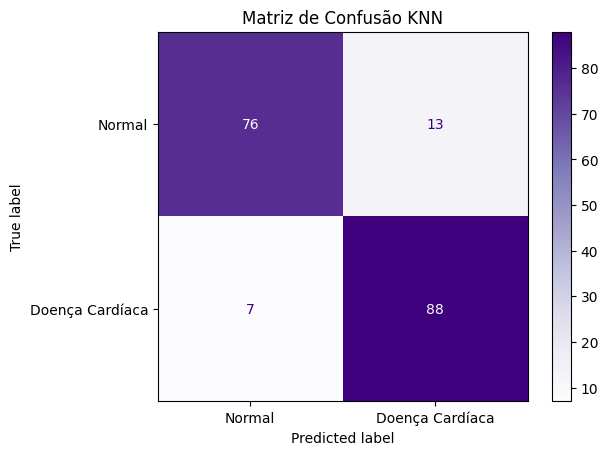

In [251]:
create_conf_matrix(y_pred_knn, 'KNN')

<Figure size 800x600 with 0 Axes>

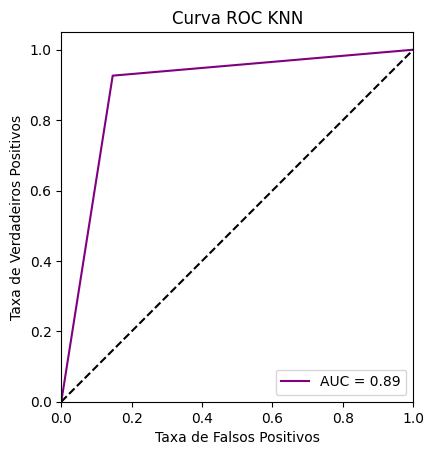

In [252]:
create_roc_curve(y_pred_knn, 'KNN')

In [253]:
# Métricas KNN

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
auc_knn = roc_auc_score(y_test, y_pred_knn)

print(f"Accuracy KNN: {accuracy_knn:.2f}")
print(f"Precision KNN: {precision_knn:.2f}")
print(f"Recall KNN: {recall_knn:.2f}")
print(f"AUC KNN: {auc_knn:.2f}")

Accuracy KNN: 0.89
Precision KNN: 0.87
Recall KNN: 0.93
AUC KNN: 0.89


## Modelo Random Forest

Algoritmos de **Random Forest** criam várias árvores de decisão durante o treinamento. Cada árvore é treinada com uma parte aleatória dos dados. Durante a previsão, cada árvore faz sua própria previsão e, em seguida, o algorirmo combina todas essas previsões para chegar a uma decisão final. 

Os hiperparâmetros utilizados na otimização do modelo foram:
- n_estimators: número de árvores de decisão no modelo; 
- max_depth: profundidade máxima de cada árvore de decisão; 
- min_samples_split: número mínimo de amostras necessárias para dividir um nó interno da árvore; 
- min_samples_leaf: número mínimo de amostras necessárias para ser uma folha (nó final) da árvore.

In [254]:
# Otimização de hiperparâmetros

rf_parameters = {'n_estimators': randint(50,500),
                'max_depth': randint(1,20),
                'min_samples_split': randint(2, 10),  
                'min_samples_leaf': randint(1, 5)}

rf = RandomForestClassifier()
rf_random_search = RandomizedSearchCV(rf, param_distributions=rf_parameters, n_iter=20, cv=5)

rf_random_search.fit(X_train, y_train)

best_rf_params = rf_random_search.best_params_
best_rf_model = rf_random_search.best_estimator_

print('Melhores hiperparâmetros para Random Forest: ', best_rf_params)

Melhores hiperparâmetros para Random Forest:  {'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 271}


In [255]:
y_pred_rf = best_rf_model.predict(X_test)  # previsão utilizando dataset de teste

<Figure size 800x600 with 0 Axes>

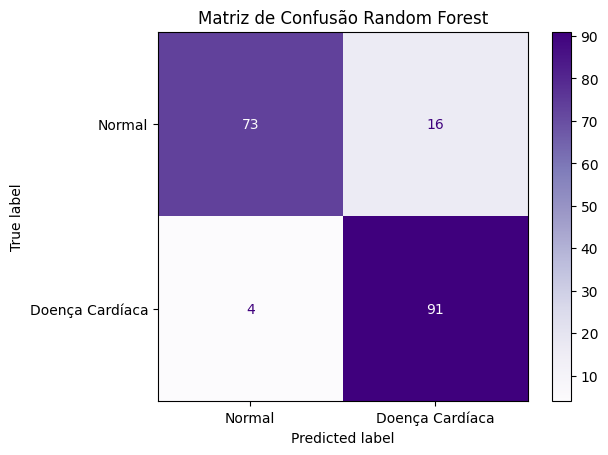

In [256]:
create_conf_matrix(y_pred_rf, 'Random Forest') 

<Figure size 800x600 with 0 Axes>

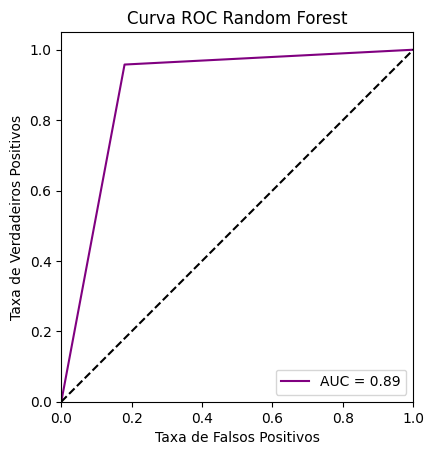

In [257]:
create_roc_curve(y_pred_rf, 'Random Forest')

In [258]:
# Métricas Random Forest

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf)

print(f"Accuracy Random Forest: {accuracy_rf:.2f}")
print(f"Precision Random Forest: {precision_rf:.2f}")
print(f"Recall Random Forest: {recall_rf:.2f}")
print(f"AUC Random Forest: {auc_rf:.2f}")

Accuracy Random Forest: 0.89
Precision Random Forest: 0.85
Recall Random Forest: 0.96
AUC Random Forest: 0.89


## Conclusão

In [259]:
metrics_comp = pd.DataFrame({
    'Accuracy': [accuracy_knn, accuracy_rf],
    'Precision': [precision_knn, precision_rf],
    'Recall': [recall_knn, recall_rf],
    'AUC': [auc_knn, auc_rf]},
    index=['KNN', 'Random Forest'])

metrics_comp

,Accuracy,Precision,Recall,AUC
KNN,0.891304,0.871287,0.926316,0.890124
Random Forest,0.891304,0.850467,0.957895,0.889060


Para todas as métricas analisadas nesse projeto, o modelo de **Random Forest** obteve maior pontuação. Sendo algoritmos de Random Forest mais complexos e robustos que de KNN, podemos dizer que esse resultado é esperado, de forma geral. 

Vale ressaltar ainda que, no contexto de diagnóstico de doenças, damos elevada importância a altos valores de verdadeiros positivos e baixos falsos negativos, considerando a consequência que esse resultado traria para o tratamento correto do paciente.

Assim, a pontuação de 0.95 em recall para o modelo de Random Forest mostra que ele é melhor em diagnosticar corretamente indivíduos que de fato possuem doenças carídacas, em comparação ao de KNN.